# Machine learning - Assignment 6 - Tree-based approaches
____
**Author**: Kemal Cikota

**Course**: Machine learning
____

## Introduction

In this assignment, i will explore the use of **tree-based** machine learning algorithms like classification trees, regression trees and also explore techniques on how to improve the tree-based approaches like bagging and boosting in order to get better performance metrics.

I used [this source](https://rdrr.io/cran/ISLR/man/Carseats.html) when trying to understand what the different variables meant and what they did. This made it easier for me to understand the outputs that i got.

## Conceptual Questions

**1. explain the differences between bagging and boosting and explain how machine learning methods in general use theese strategies to build robust models using tree models?**

ääääääääääää

**2. What are the main differences between Random Forest and AdaBoost regarding how the b ase learners are trained, how samples are weighted, how predictors are made and how robust are they regarding overfitting?**

ääääääääääää

## Practical

For the practical part of the assignment, i have to work with the carseats.csv dataset which contains sales of child car seats at 400 different stores. It shows data like how many units are sold, how much money is invested in advertising, different prices of carseats. And there is also a classifier feature that is rating of how good a shelving location is for a carseat and much more.

### Load the data and get an overview of the data

In [158]:
import pandas as pd # Never coded in R before but this seems to be the equivalent of library(pandas) in R
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import numpy as np

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA # pip install scikit-learn
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from sklearn.tree import plot_tree

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree



# load boston.csv
carseats = pd.read_csv('Carseats.csv')

# Set pandas option to display all columns
pd.set_option('display.max_columns', None)

print(carseats.describe(), end="\n\n")

# I count the categorical separate instances manually as i couldnt find a good function to do it. 
categorical_columns = carseats.select_dtypes(include=['object', 'category']).columns

for col in categorical_columns:
    print(f"Summary for {col}:")
    print(carseats[col].value_counts(), end="\n\n")

       Unnamed: 0       Sales   CompPrice      Income  Advertising  \
count  400.000000  400.000000  400.000000  400.000000   400.000000   
mean   200.500000    7.496325  124.975000   68.657500     6.635000   
std    115.614301    2.824115   15.334512   27.986037     6.650364   
min      1.000000    0.000000   77.000000   21.000000     0.000000   
25%    100.750000    5.390000  115.000000   42.750000     0.000000   
50%    200.500000    7.490000  125.000000   69.000000     5.000000   
75%    300.250000    9.320000  135.000000   91.000000    12.000000   
max    400.000000   16.270000  175.000000  120.000000    29.000000   

       Population       Price         Age   Education  
count  400.000000  400.000000  400.000000  400.000000  
mean   264.840000  115.795000   53.322500   13.900000  
std    147.376436   23.676664   16.200297    2.620528  
min     10.000000   24.000000   25.000000   10.000000  
25%    139.000000  100.000000   39.750000   12.000000  
50%    272.000000  117.000000   5

In [159]:
print("total amount of datapoints: ", carseats.shape[0], end="\n\n")

total amount of datapoints:  400



In [160]:
carseats

Unnamed: 0  Sales  CompPrice  Income  Advertising  Population  Price  \
0             1   9.50        138      73           11         276    120   
1             2  11.22        111      48           16         260     83   
2             3  10.06        113      35           10         269     80   
3             4   7.40        117     100            4         466     97   
4             5   4.15        141      64            3         340    128   
..          ...    ...        ...     ...          ...         ...    ...   
395         396  12.57        138     108           17         203    128   
396         397   6.14        139      23            3          37    120   
397         398   7.41        162      26           12         368    159   
398         399   5.94        100      79            7         284     95   
399         400   9.71        134      37            0          27    120   

    ShelveLoc  Age  Education Urban   US  
0         Bad   42         17   Yes  Yes  
1        Good   65         10   Yes  Yes  
2      Medium   59         12   Yes  Yes  
3      Medium   55         14   Yes  Yes  
4         Bad   38         13   Yes   No  
..        ...  ...        ...   ...  ...  
395      Good   33         14   Yes  Yes  
396    Medium   55         11    No  Yes  
397    Medium   40         18   Yes  Yes  
398       Bad   50         12   Yes  Yes  
399      Good   49         16   Yes  Yes  

[400 rows x 12 columns]

I now plotted the pairwise correlation between the quantitative variables. This means that i had to drop the classifier features as was shown in the example.

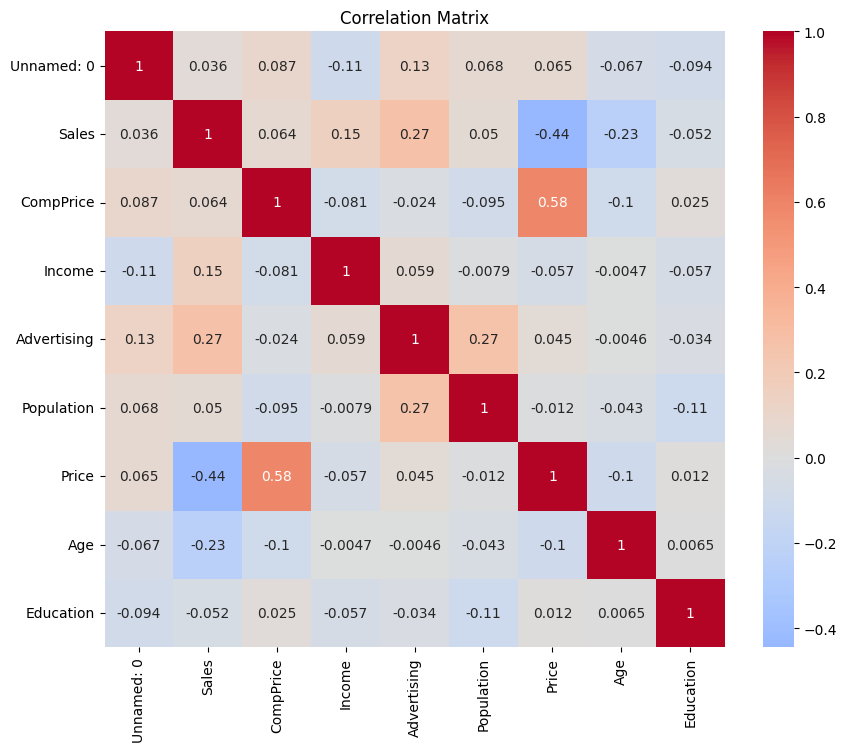

In [161]:
# drop direction column
carseats = carseats.drop(columns=['Urban', 'US', 'ShelveLoc'])

correlation_matrix = carseats.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

Pearson Correlation Coefficient: -0.44, P-value: 7.62e-21


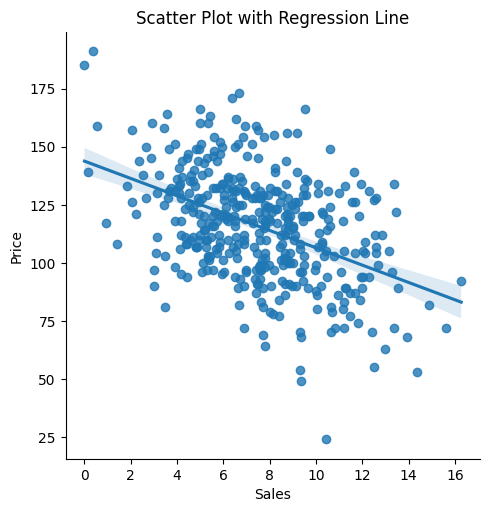

In [162]:
# Step 1 (plots)

corCoef, pValue = stats.pearsonr(carseats['Sales'], carseats['Price'])

print(f"Pearson Correlation Coefficient: {corCoef:.2f}, P-value: {pValue:.2e}")

sns.lmplot(data=carseats, x='Sales', y='Price', ci=95)

# Add labels to the plot
plt.xlabel("Sales")
plt.ylabel("Price")
plt.title(f"Scatter Plot with Regression Line")
plt.show() # Remember to make the window bigger to see the plot

INTERPRETATION OF RESULTS

### Learn ans assess classification trees

In [163]:
# Create binary classification target variable 'High'
carseats['High'] = np.where(carseats['Sales'] <= 8, "No", "Yes")

# Drop 'Sales' since it should not be a predictor
carseats = carseats.drop(columns=['Sales'])

# Separate features (X) and target variable (y)
X = carseats.drop(columns=['High'])
y = carseats['High'].map({'No': 0, 'Yes': 1})

X = pd.get_dummies(X, drop_first=False)

# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the decision tree classifier
tree_model = DecisionTreeClassifier(random_state=42)

# Train the model
tree_model.fit(X_train, y_train)

# Make predictions
y_pred = tree_model.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# number of terminal nodes
print(f"Number of terminal nodes: {tree_model.get_n_leaves()}")

# residual mean deviance
print(f"Residual mean deviance: {tree_model.score(X_test, y_test)}")

plt.figure(figsize=(200,100))
plot_tree(tree_model, filled=True, feature_names=X.columns, class_names=["No", "Yes"])
plt.show()



Model Accuracy: 0.57
Number of terminal nodes: 62
Residual mean deviance: 0.575


INTERPRETATION OF RESULTS

In [164]:
# Create a confusion matrix as a crosstab
confusion_tab = pd.crosstab(
    index=y_pred, 
    columns=y_test, 
    rownames=['Predicted'], 
    colnames=['Actual']
)
print("Confusion Table (like R's table(pred, actual)):")
print(confusion_tab)

Confusion Table (like R's table(pred, actual)):
Actual      0   1
Predicted        
0          30  21
1          13  16


INTERPREATION OF RESULTS

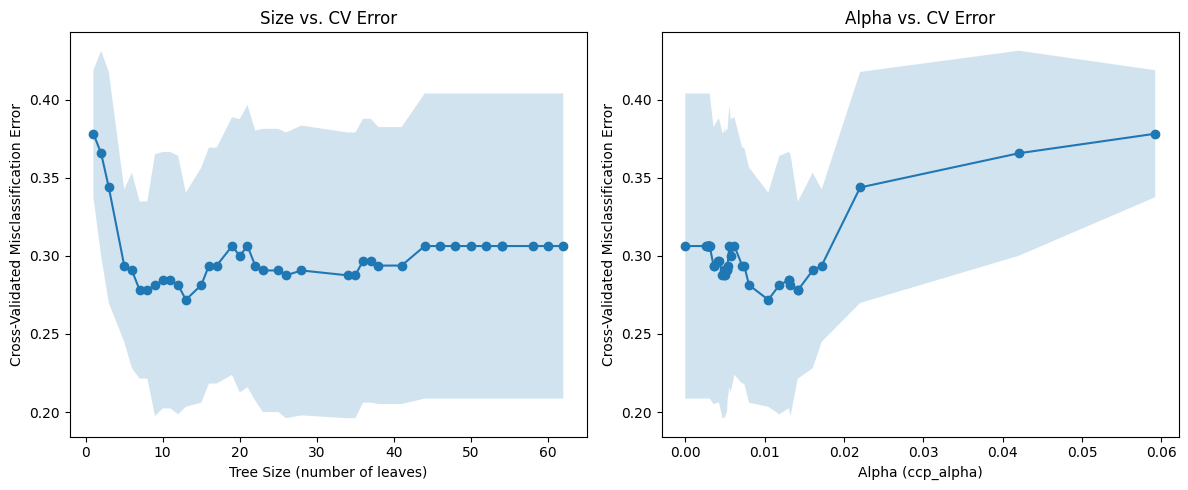

Best alpha: 0.010463235294117652
CV error at best alpha: 0.271875


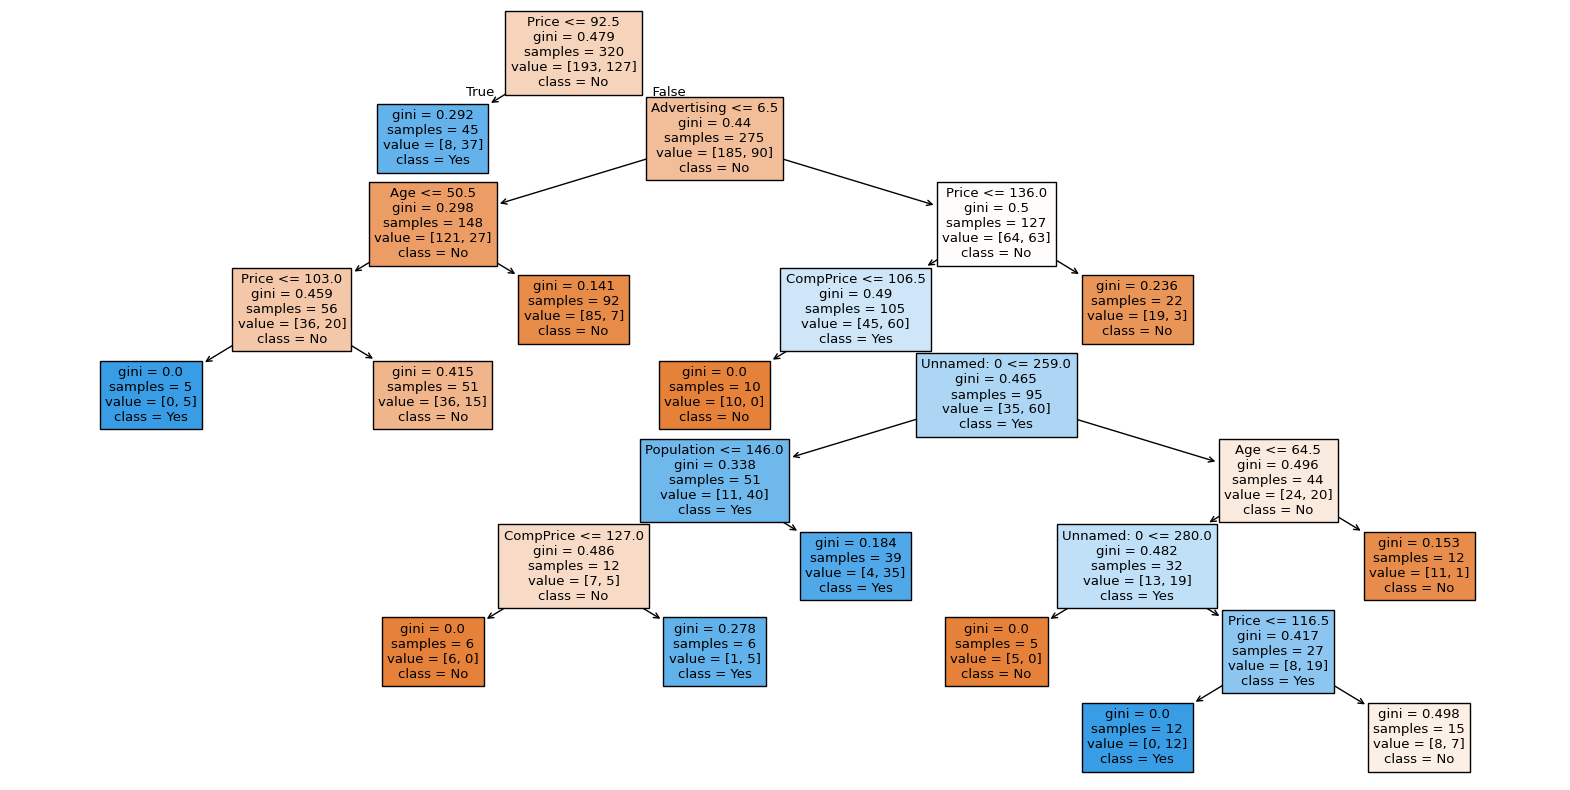

Model Accuracy: 0.62


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# -------------------------------------------------------
# 1. Compute the cost-complexity pruning path
# -------------------------------------------------------
path = DecisionTreeClassifier(random_state=42).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Arrays to store results
alpha_values = []
mean_errors = []
std_errors = []
tree_sizes = []

# -------------------------------------------------------
# 2. For each alpha, cross-validate a DecisionTreeClassifier
#    and also fit once on the entire training set to get the size
# -------------------------------------------------------
for alpha in ccp_alphas:
    temp_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    
    # 10-fold cross-validation for accuracy
    cv_scores = cross_val_score(temp_tree, X_train, y_train, cv=10, scoring='accuracy')
    
    # Misclassification error is (1 - accuracy)
    errors = 1 - cv_scores
    
    # Fit on the entire training set to measure the actual size (leaves)
    temp_tree.fit(X_train, y_train)
    size = temp_tree.get_n_leaves()
    
    alpha_values.append(alpha)
    mean_errors.append(errors.mean())
    std_errors.append(errors.std())
    tree_sizes.append(size)

# -------------------------------------------------------
# 3. Side-by-side plots: (size vs. error) and (alpha vs. error)
# -------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# -- Plot (A): Tree size vs. CV error
axes[0].plot(tree_sizes, mean_errors, marker='o')
axes[0].fill_between(
    tree_sizes,
    np.array(mean_errors) - np.array(std_errors),
    np.array(mean_errors) + np.array(std_errors),
    alpha=0.2
)
axes[0].set_xlabel("Tree Size (number of leaves)")
axes[0].set_ylabel("Cross-Validated Misclassification Error")
axes[0].set_title("Size vs. CV Error")

# -- Plot (B): Alpha vs. CV error
axes[1].plot(alpha_values, mean_errors, marker='o')
axes[1].fill_between(
    alpha_values,
    np.array(mean_errors) - np.array(std_errors),
    np.array(mean_errors) + np.array(std_errors),
    alpha=0.2
)
axes[1].set_xlabel("Alpha (ccp_alpha)")
axes[1].set_ylabel("Cross-Validated Misclassification Error")
axes[1].set_title("Alpha vs. CV Error")

plt.tight_layout()
plt.show()

# -------------------------------------------------------
# 4. Identify best alpha & retrain final pruned tree (optional)
# -------------------------------------------------------
best_idx = np.argmin(mean_errors)
best_alpha = alpha_values[best_idx]
print("Best alpha:", best_alpha)
print("CV error at best alpha:", mean_errors[best_idx])

pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
pruned_tree.fit(X_train, y_train)

plt.figure(figsize=(20,10))
plot_tree(pruned_tree, filled=True, feature_names=X_train.columns, class_names=["No", "Yes"])
plt.show()




INTERPRETATION OF RESULTS

In [168]:
# Create a confusion matrix as a crosstab
y_pred = pruned_tree.predict(X_test)
confusion_tab = pd.crosstab(
    index=y_pred, 
    columns=y_test, 
    rownames=['Predicted'], 
    colnames=['Actual']
)
print("Confusion Table (like R's table(pred, actual)):")
print(confusion_tab)

# print accuracy
y_pred = pruned_tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

Confusion Table (like R's table(pred, actual)):
Actual      0   1
Predicted        
0          32  19
1          11  18
Model Accuracy: 0.62


INTERPRETATION OF RESULTS

### Learn and assess regression trees

Now we want to use regression tree-based models with the Boston dataset that only includes numerical data which is perfect for regression based solutions.

Regression tree for Boston dataset (Python equivalent of R's tree()):
Number of terminal nodes: 8
Residual mean deviance (training MSE): 14.921
Distribution of residuals (training set):
   Min.   : -12.113
   1Q     : -2.416
   Median : 0.002
   3Q     : 1.984
   Max.   : 27.784

Test MSE: 26.008


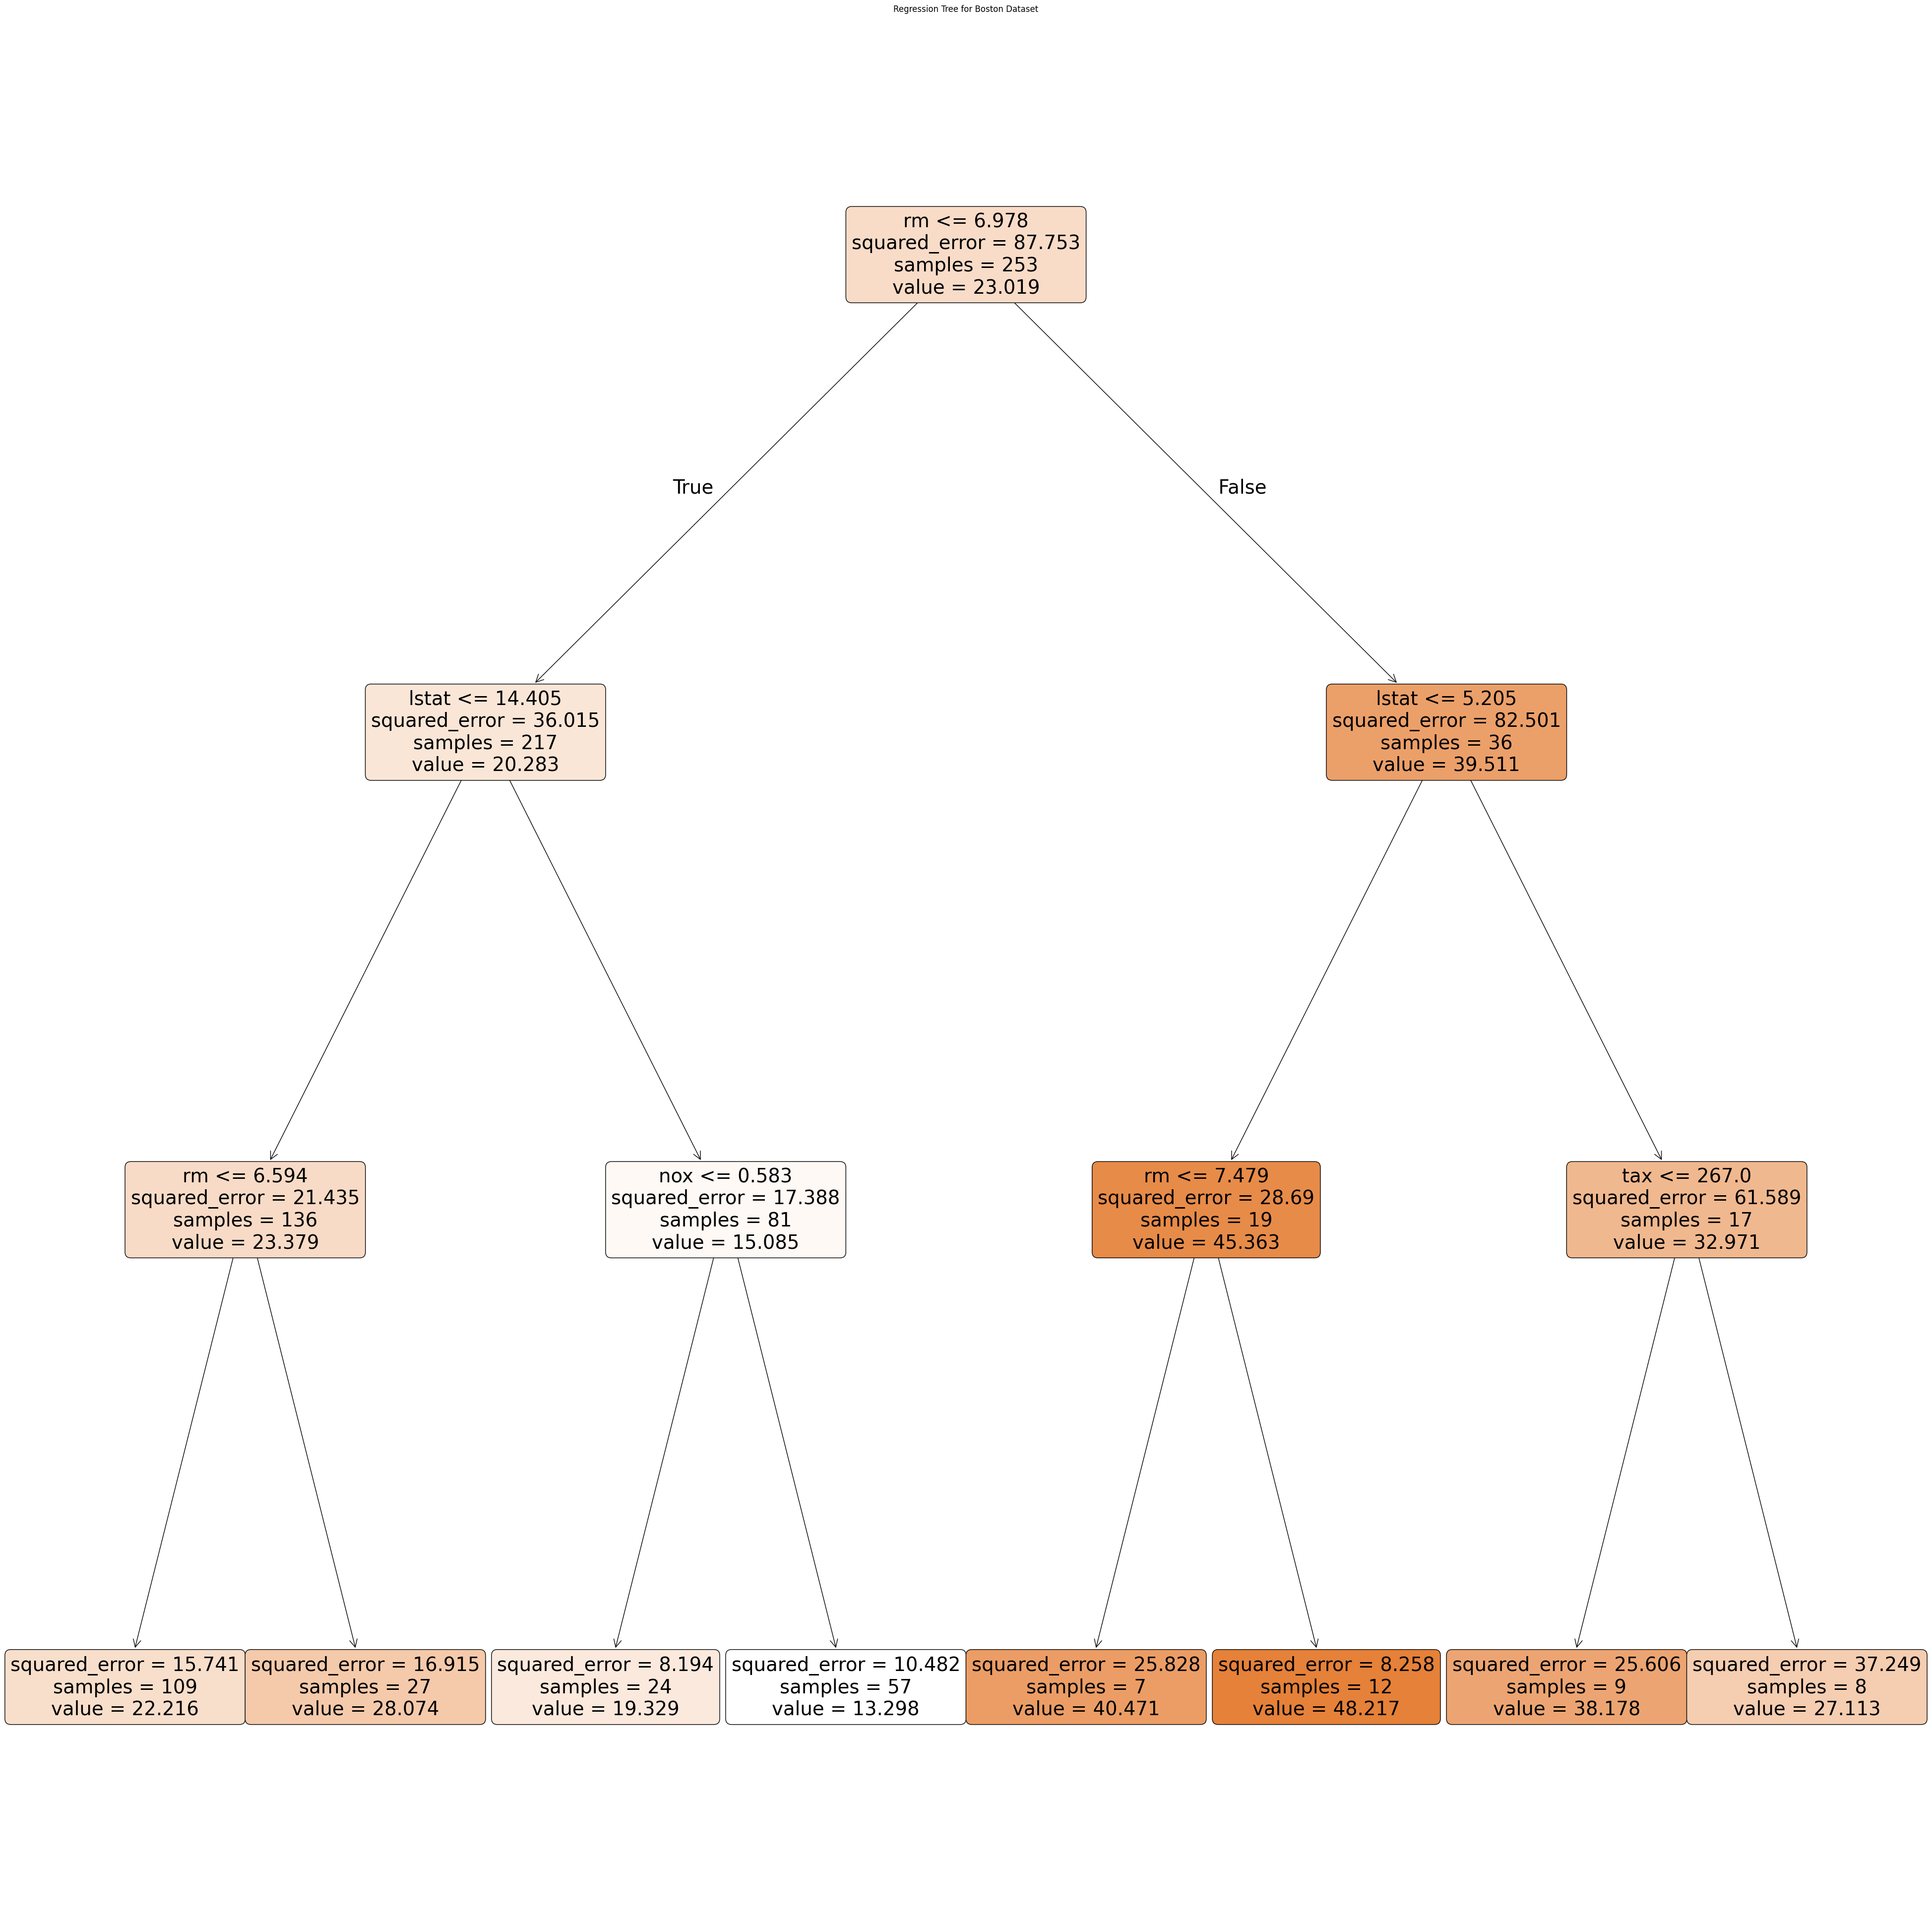

In [177]:
# load boston.csv
boston = pd.read_csv('Boston.csv')

# Set pandas option to display all columns
pd.set_option('display.max_columns', None)

import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 1. Prepare the data and split into train/test (50/50)
# -------------------------------------------------------
# We'll mimic R's approach of taking half the data for training.
# In R: set.seed(1); train=sample(1:nrow(Boston), nrow(Boston)/2)

np.random.seed(1)  # for reproducibility

# Suppose 'medv' is the target column, just like in R
X = boston.drop(columns=['medv'])
y = boston['medv']

# Randomly choose half the rows as the training set
train_indices = np.random.choice(len(X), size=len(X)//2, replace=False)
test_indices = np.setdiff1d(np.arange(len(X)), train_indices)

X_train = X.iloc[train_indices]
y_train = y.iloc[train_indices]
X_test = X.iloc[test_indices]
y_test = y.iloc[test_indices]

# -------------------------------------------------------
# 2. Fit a regression tree on the training subset
# -------------------------------------------------------
tree_boston = DecisionTreeRegressor(random_state=1, max_depth=3, min_samples_leaf=5) 
tree_boston.fit(X_train, y_train)

# -------------------------------------------------------
# 3. "Summary"-like output
# -------------------------------------------------------
# Number of terminal nodes (analogous to 'Number of terminal nodes:' in R)
n_leaves = tree_boston.get_n_leaves()

# Residual mean deviance is basically the training MSE
train_preds = tree_boston.predict(X_train)
train_mse = mean_squared_error(y_train, train_preds)

# We can also examine the distribution of residuals on the training set
residuals = y_train - train_preds
res_min = residuals.min()
res_q1 = np.quantile(residuals, 0.25)
res_median = np.median(residuals)
res_q3 = np.quantile(residuals, 0.75)
res_max = residuals.max()

print("Regression tree for Boston dataset (Python equivalent of R's tree()):")
print(f"Number of terminal nodes: {n_leaves}")
print(f"Residual mean deviance (training MSE): {train_mse:.3f}")
print("Distribution of residuals (training set):")
print(f"   Min.   : {res_min:.3f}")
print(f"   1Q     : {res_q1:.3f}")
print(f"   Median : {res_median:.3f}")
print(f"   3Q     : {res_q3:.3f}")
print(f"   Max.   : {res_max:.3f}")

# -------------------------------------------------------
# 4. Evaluate on the test set
# -------------------------------------------------------
test_preds = tree_boston.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds)
print(f"\nTest MSE: {test_mse:.3f}")

# -------------------------------------------------------
# 5. Plot the tree (similar to plot(tree.boston); text(tree.boston))
# -------------------------------------------------------
plt.figure(figsize=(50, 50))
plot_tree(
    tree_boston,
    feature_names=X.columns,
    filled=True,
    rounded=True
)
plt.title("Regression Tree for Boston Dataset")
plt.show()


INTERPRETATION OF RESULTS

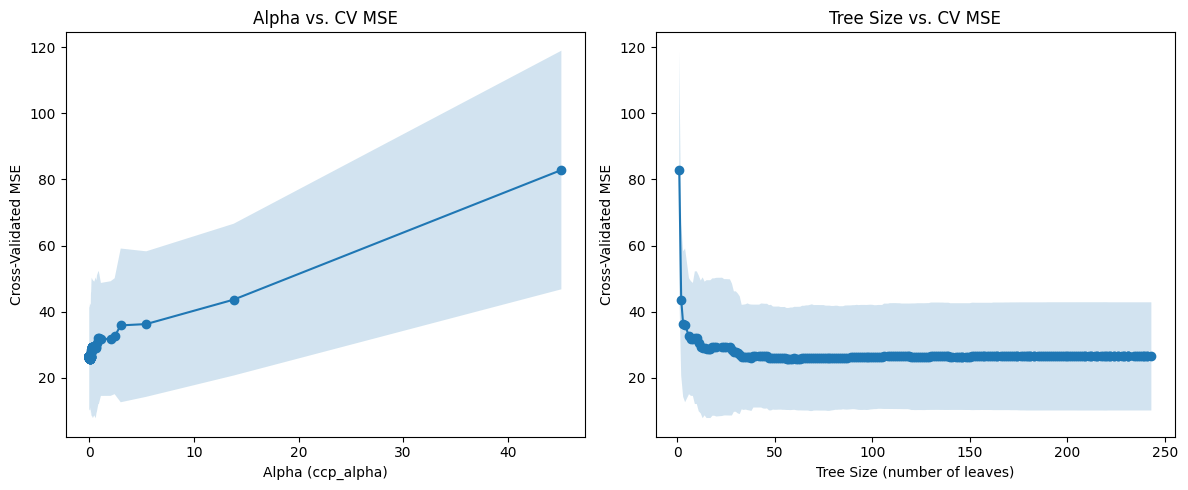

Best alpha: 0.04034914361000838
Cross-validated MSE at best alpha: 25.70247791867495

Test MSE (pruned tree): 18.24121103436141


In [178]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# -------------------------------------------------------
# Perform cost-complexity pruning path
# -------------------------------------------------------
path = DecisionTreeRegressor(random_state=1).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Arrays to store results
alpha_values = []
mean_cv_errors = []
std_cv_errors = []
tree_sizes = []

# -------------------------------------------------------
# For each alpha, train and cross-validate a DecisionTreeRegressor
# -------------------------------------------------------
for alpha in ccp_alphas:
    temp_tree = DecisionTreeRegressor(random_state=1, ccp_alpha=alpha)
    
    # 10-fold CV for MSE (scoring='neg_mean_squared_error' -> need to negate)
    cv_scores = cross_val_score(temp_tree, X_train, y_train,
                                scoring='neg_mean_squared_error', cv=10)
    # Convert from negative MSE to MSE
    mse_scores = -cv_scores
    
    # Fit on entire training set once to measure actual tree size
    temp_tree.fit(X_train, y_train)
    n_leaves = temp_tree.get_n_leaves()
    
    alpha_values.append(alpha)
    mean_cv_errors.append(mse_scores.mean())
    std_cv_errors.append(mse_scores.std())
    tree_sizes.append(n_leaves)

# -------------------------------------------------------
# Plot (1) Alpha vs. CV Error, (2) Tree Size vs. CV Error
# -------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# -- (A) Alpha vs. CV Error
axes[0].plot(alpha_values, mean_cv_errors, marker='o')
axes[0].fill_between(
    alpha_values,
    np.array(mean_cv_errors) - np.array(std_cv_errors),
    np.array(mean_cv_errors) + np.array(std_cv_errors),
    alpha=0.2
)
axes[0].set_xlabel('Alpha (ccp_alpha)')
axes[0].set_ylabel('Cross-Validated MSE')
axes[0].set_title('Alpha vs. CV MSE')

# -- (B) Tree Size vs. CV Error
axes[1].plot(tree_sizes, mean_cv_errors, marker='o')
axes[1].fill_between(
    tree_sizes,
    np.array(mean_cv_errors) - np.array(std_cv_errors),
    np.array(mean_cv_errors) + np.array(std_cv_errors),
    alpha=0.2
)
axes[1].set_xlabel('Tree Size (number of leaves)')
axes[1].set_ylabel('Cross-Validated MSE')
axes[1].set_title('Tree Size vs. CV MSE')

plt.tight_layout()
plt.show()

# -------------------------------------------------------
# Identify best alpha (lowest MSE) and refit a final pruned tree
# -------------------------------------------------------
best_idx = np.argmin(mean_cv_errors)
best_alpha = alpha_values[best_idx]
print("Best alpha:", best_alpha)
print("Cross-validated MSE at best alpha:", mean_cv_errors[best_idx])

pruned_tree = DecisionTreeRegressor(random_state=1, ccp_alpha=best_alpha)
pruned_tree.fit(X_train, y_train)

# Evaluate on the test set
test_preds_pruned = pruned_tree.predict(X_test)
test_mse_pruned = mean_squared_error(y_test, test_preds_pruned)
print("\nTest MSE (pruned tree):", test_mse_pruned)


INTERPRETATION OF RESULTS

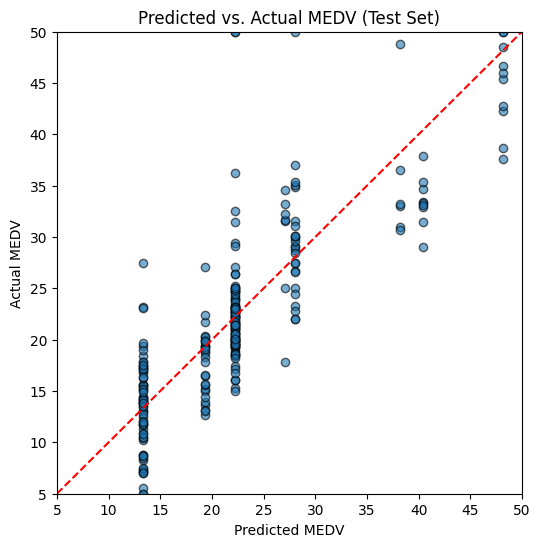

Test MSE: 26.00834875580148


In [179]:
# 1. Generate predictions on the test set
yhat = tree_boston.predict(X_test)

# 2. Plot predicted vs. actual
plt.figure(figsize=(6, 6))
plt.scatter(yhat, y_test, alpha=0.6, edgecolors='k')
plt.xlabel("Predicted MEDV")
plt.ylabel("Actual MEDV")
plt.title("Predicted vs. Actual MEDV (Test Set)")

# 3. Plot the line y = x for reference
lims = [min(yhat.min(), y_test.min()), max(yhat.max(), y_test.max())]
plt.plot(lims, lims, 'r--')  # diagonal line
plt.xlim(lims)
plt.ylim(lims)

plt.show()

# 4. Compute and display MSE
mse = np.mean((yhat - y_test)**2)
print("Test MSE:", mse)


INTERPRETATION OF RESULTS

### Learn and assess regression bagging trees and random forest

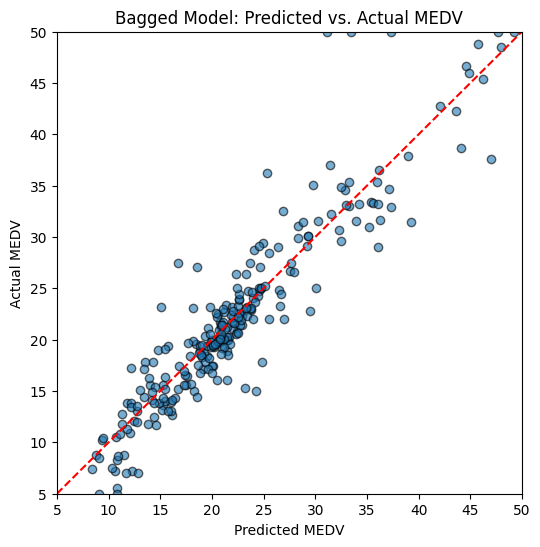

Test MSE (Bagged Model): 11.071022049486121

Feature Importances:
       Feature  Importance
6           rm    0.572738
13       lstat    0.251502
8          dis    0.040805
1         crim    0.026792
5          nox    0.025290
0   Unnamed: 0    0.017843
7          age    0.014766
12       black    0.013513
11     ptratio    0.013462
10         tax    0.011277
3        indus    0.004303
9          rad    0.003788
4         chas    0.002235
2           zn    0.001687
Mean of squared residuals (OOB): 16.58060
% Var explained (OOB): 81.11


In [185]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 1. Define X and y
# -------------------------------------------------------
X = boston.drop(columns=['medv'])
y = boston['medv']

bag_boston = RandomForestRegressor(
    n_estimators=500,
    max_features=X_train.shape[1],  # same as settingmtry = 13 which ises all features for each split
    bootstrap=True,
    oob_score=True,
    random_state=1
)
bag_boston.fit(X_train, y_train)

# -------------------------------------------------------
# 3. Predict on the test set
# -------------------------------------------------------
yhat_bag = bag_boston.predict(X_test)

# -------------------------------------------------------
# 4. Plot predicted vs. actual
# -------------------------------------------------------
plt.figure(figsize=(6, 6))
plt.scatter(yhat_bag, y_test, alpha=0.6, edgecolors='k')
plt.xlabel("Predicted MEDV")
plt.ylabel("Actual MEDV")
plt.title("Bagged Model: Predicted vs. Actual MEDV")

# Draw a 45-degree line for reference
lims = [min(yhat_bag.min(), y_test.min()), max(yhat_bag.max(), y_test.max())]
plt.plot(lims, lims, 'r--')
plt.xlim(lims)
plt.ylim(lims)
plt.show()

# -------------------------------------------------------
# 5. Compute test MSE
# -------------------------------------------------------
mse_bag = mean_squared_error(y_test, yhat_bag)
print("Test MSE (Bagged Model):", mse_bag)

# -------------------------------------------------------
# 6. (Optional) View feature importances
# -------------------------------------------------------
importances = bag_boston.feature_importances_
features = X.columns
feat_importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
feat_importance_df = feat_importance_df.sort_values(by="Importance", ascending=False)

print("\nFeature Importances:")
print(feat_importance_df)

oob_preds = bag_boston.oob_prediction_

# OOB MSE (analogous to "Mean of squared residuals" in R)
oob_mse = mean_squared_error(y_train, oob_preds)

# OOB R^2 (fraction of variance explained), scikit-learn calculates this automatically
oob_r2 = bag_boston.oob_score_

# Convert R^2 to % Var explained
oob_var_explained = 100 * oob_r2

print(f"Mean of squared residuals (OOB): {oob_mse:.5f}")
print(f"% Var explained (OOB): {oob_var_explained:.2f}")

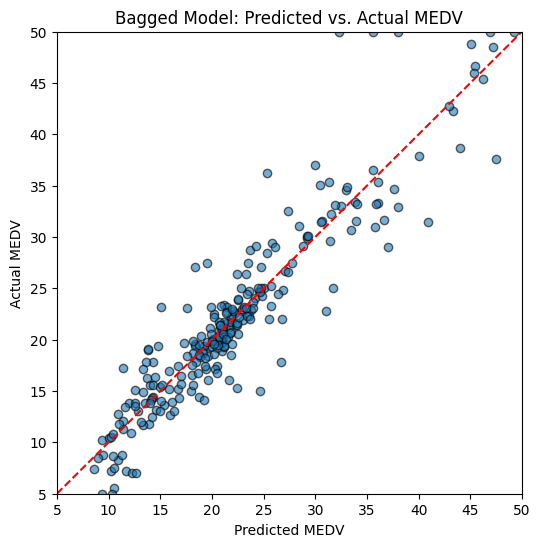

Test MSE (Bagged Model): 11.160242529644266

Feature Importances:
       Feature  Importance
6           rm    0.600212
13       lstat    0.226871
8          dis    0.041182
5          nox    0.030586
1         crim    0.021742
12       black    0.019356
0   Unnamed: 0    0.015697
7          age    0.014745
10         tax    0.011418
11     ptratio    0.008078
9          rad    0.003175
3        indus    0.003047
2           zn    0.002202
4         chas    0.001687
Mean of squared residuals (OOB): 18.76511
% Var explained (OOB): 78.62


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 1. Define X and y
# -------------------------------------------------------
X = boston.drop(columns=['medv'])
y = boston['medv']

bag_boston = RandomForestRegressor(
    n_estimators=25,
    max_features=X_train.shape[1],  # same as settingmtry = 13 which ises all features for each split
    bootstrap=True,
    oob_score=True,
    random_state=1
)
bag_boston.fit(X_train, y_train)

# -------------------------------------------------------
# 3. Predict on the test set
# -------------------------------------------------------
yhat_bag = bag_boston.predict(X_test)

# -------------------------------------------------------
# 4. Plot predicted vs. actual
# -------------------------------------------------------
plt.figure(figsize=(6, 6))
plt.scatter(yhat_bag, y_test, alpha=0.6, edgecolors='k')
plt.xlabel("Predicted MEDV")
plt.ylabel("Actual MEDV")
plt.title("Bagged Model: Predicted vs. Actual MEDV")

# Draw a 45-degree line for reference
lims = [min(yhat_bag.min(), y_test.min()), max(yhat_bag.max(), y_test.max())]
plt.plot(lims, lims, 'r--')
plt.xlim(lims)
plt.ylim(lims)
plt.show()

# -------------------------------------------------------
# 5. Compute test MSE
# -------------------------------------------------------
mse_bag = mean_squared_error(y_test, yhat_bag)
print("Test MSE (Bagged Model):", mse_bag)

# -------------------------------------------------------
# 6. (Optional) View feature importances
# -------------------------------------------------------
importances = bag_boston.feature_importances_
features = X.columns
feat_importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
feat_importance_df = feat_importance_df.sort_values(by="Importance", ascending=False)

print("\nFeature Importances:")
print(feat_importance_df)

oob_preds = bag_boston.oob_prediction_

# OOB MSE (analogous to "Mean of squared residuals" in R)
oob_mse = mean_squared_error(y_train, oob_preds)

# OOB R^2 (fraction of variance explained), scikit-learn calculates this automatically
oob_r2 = bag_boston.oob_score_

# Convert R^2 to % Var explained
oob_var_explained = 100 * oob_r2

print(f"Mean of squared residuals (OOB): {oob_mse:.5f}")
print(f"% Var explained (OOB): {oob_var_explained:.2f}")

INTERPRETATION OF RESULTS

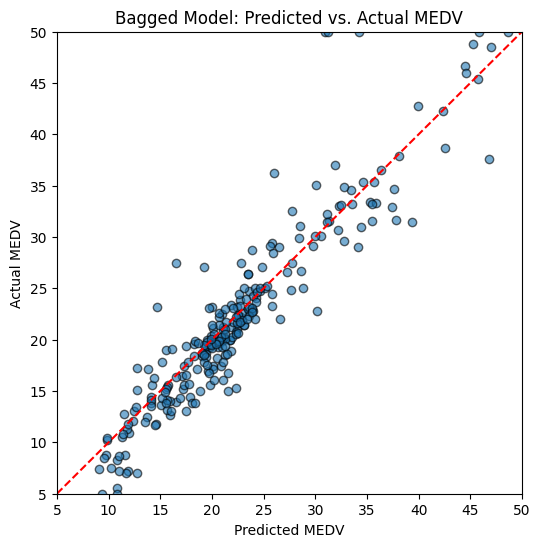

Test MSE (Bagged Model): 11.169320679367592

Feature Importances:
       Feature  Importance
6           rm    0.384064
13       lstat    0.272006
11     ptratio    0.055674
0   Unnamed: 0    0.054816
8          dis    0.042311
1         crim    0.040531
5          nox    0.038456
10         tax    0.026708
7          age    0.025004
3        indus    0.022870
12       black    0.018394
4         chas    0.009161
9          rad    0.005080
2           zn    0.004925
Mean of squared residuals (OOB): 14.39685
% Var explained (OOB): 83.59


In [187]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 1. Define X and y
# -------------------------------------------------------
X = boston.drop(columns=['medv'])
y = boston['medv']

bag_boston = RandomForestRegressor(
    n_estimators=500,
    max_features=6,  # same as settingmtry = 13 which ises all features for each split
    bootstrap=True,
    oob_score=True,
    random_state=1
)
bag_boston.fit(X_train, y_train)

# -------------------------------------------------------
# 3. Predict on the test set
# -------------------------------------------------------
yhat_bag = bag_boston.predict(X_test)

# -------------------------------------------------------
# 4. Plot predicted vs. actual
# -------------------------------------------------------
plt.figure(figsize=(6, 6))
plt.scatter(yhat_bag, y_test, alpha=0.6, edgecolors='k')
plt.xlabel("Predicted MEDV")
plt.ylabel("Actual MEDV")
plt.title("Bagged Model: Predicted vs. Actual MEDV")

# Draw a 45-degree line for reference
lims = [min(yhat_bag.min(), y_test.min()), max(yhat_bag.max(), y_test.max())]
plt.plot(lims, lims, 'r--')
plt.xlim(lims)
plt.ylim(lims)
plt.show()

# -------------------------------------------------------
# 5. Compute test MSE
# -------------------------------------------------------
mse_bag = mean_squared_error(y_test, yhat_bag)
print("Test MSE (Bagged Model):", mse_bag)

# -------------------------------------------------------
# 6. (Optional) View feature importances
# -------------------------------------------------------
importances = bag_boston.feature_importances_
features = X.columns
feat_importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
feat_importance_df = feat_importance_df.sort_values(by="Importance", ascending=False)

print("\nFeature Importances:")
print(feat_importance_df)

oob_preds = bag_boston.oob_prediction_

# OOB MSE (analogous to "Mean of squared residuals" in R)
oob_mse = mean_squared_error(y_train, oob_preds)

# OOB R^2 (fraction of variance explained), scikit-learn calculates this automatically
oob_r2 = bag_boston.oob_score_

# Convert R^2 to % Var explained
oob_var_explained = 100 * oob_r2

print(f"Mean of squared residuals (OOB): {oob_mse:.5f}")
print(f"% Var explained (OOB): {oob_var_explained:.2f}")

INTERPRETATION OF RESULT

### Learn and assess regression boosting (trees)